In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2
from PFNExperiments.LatentFactorModels.Training.TrainerCurriculumCNF_LatentFactor import TrainerCurriculumCNF_LatentFactor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LatentFactorModels.ComparisonModels.Hamiltionian_MC_Numpyro import Hamiltionian_MC
from PFNExperiments.Evaluation.Evaluate import Evaluate, results_dict_to_data_x_tuple, result_dict_to_latent_variable_convert_mu_sigma_to_beta, results_dict_to_data_x_tuple_transpose

In [119]:
from PFNExperiments.LatentFactorModels.GenerativeModels.Clustering.GMMs import make_gmm_program_diagonal_batched
from PFNExperiments.LatentFactorModels.GenerativeModels.Numpyro_Versions.GMM_Numpyro import make_gmm_program_diagonal
from PFNExperiments.LatentFactorModels.GenerativeModels.LatenFactorModel_abstract import return_only_x

from PFNExperiments.LatentFactorModels.ComparisonModels.MakeDefaultListComparison import make_default_list_comparison, make_reduced_list_comparison


In [87]:
'''
import pyro
import pyro.distributions as dist

class gmm_program_diagonal_class():
        

    def __init__(self,
        n: int = 100,
        p: int = 5,
        k: int = 3,
        a1: float = 5.0,
        b1: float = 2.0,
        dirichlet_beta: float = 1.0,
        lambda1: float = 3.0,
    ):
        """
        Make a probabilistic program for a univariate GMM 
        Args:   
            N: int: number of data points
            p: int: number of dimensions
            K: int: number of components
            a1: float: shape of inverse gamma prior on sigma_squared
            b1: float: scale of inverse gamma prior on sigma_squared
            dirichlet_beta: float: concentration parameter of the Dirichlet prior on the mixture weights
            lambda1: float: scale the variance for the prior on the mus
        """
        a1 = torch.tensor(a1)
        b1 = torch.tensor(b1)
        dirichlet_beta = torch.tensor(dirichlet_beta)
        lambda1 = torch.tensor(lambda1)

        p = int(p)
        n = int(n)
        k = int(k)

        self.a1 = a1
        self.b1 = b1
        self.dirichlet_beta = dirichlet_beta
        self.lambda1 = lambda1
        self.p = p
        self.n = n
        self.k = k
        
    
    def __call__(self, x: torch.tensor = None) -> dict:
        """
        A univariate GMM program

        Args:
            x: torch.tensor: the input

        Returns:
            torch.tensor: the output
        """
        #if x is not None:
        #    n = x.shape[0]
        #    p = x.shape[1]  
        
        if x is not None:
            x = x.squeeze()
        
        k = int(self.k)
        n = int(self.n)
        a1 = self.a1
        b1 = self.b1
        dirichlet_beta = self.dirichlet_beta
        lambda1 = self.lambda1
        p = int(self.p)


        sigma_squared_dist = pyro.distributions.InverseGamma(a1, b1)

        phi_dist = pyro.distributions.Dirichlet(torch.tensor([dirichlet_beta] * k))
        phi = pyro.sample("phi", phi_dist) # mixture weights
    	
        with pyro.plate("dims", p):
            with pyro.plate("components", k):
                sigma_squared = pyro.sample("sigma_squared", sigma_squared_dist)
                mu = pyro.sample("mu", dist.Normal(0, lambda1 * sigma_squared))
        
        with pyro.plate("data", n):
            z = pyro.sample("z", dist.Categorical(phi))
            mu_z = mu[z]
            sigma_squared_z = sigma_squared[z]

            cov_mat = torch.diag_embed(sigma_squared_z)  
            x = pyro.sample("x", dist.MultivariateNormal(mu_z, cov_mat), obs=x)
        #print(x.shape)
        #x = x.transpose(0, 1)
        return {
            "phi": phi,
            "mu": mu,
            "sigma_squared": sigma_squared,
            "z": z,
            "x": x,
        }
    
'''

'\nimport pyro\nimport pyro.distributions as dist\n\nclass gmm_program_diagonal_class():\n        \n\n    def __init__(self,\n        n: int = 100,\n        p: int = 5,\n        k: int = 3,\n        a1: float = 5.0,\n        b1: float = 2.0,\n        dirichlet_beta: float = 1.0,\n        lambda1: float = 3.0,\n    ):\n        """\n        Make a probabilistic program for a univariate GMM \n        Args:   \n            N: int: number of data points\n            p: int: number of dimensions\n            K: int: number of components\n            a1: float: shape of inverse gamma prior on sigma_squared\n            b1: float: scale of inverse gamma prior on sigma_squared\n            dirichlet_beta: float: concentration parameter of the Dirichlet prior on the mixture weights\n            lambda1: float: scale the variance for the prior on the mus\n        """\n        a1 = torch.tensor(a1)\n        b1 = torch.tensor(b1)\n        dirichlet_beta = torch.tensor(dirichlet_beta)\n        lambd

In [88]:
N = 50
P = 5
K = 3
BATCH_SIZE = 32
N_EPOCHS = 1
N_SAMPLES_PER_EPOCH = 1000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE

In [89]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list([
    ("n", curriculum.constant_scheduler(N)),
    ("p", curriculum.constant_scheduler(P)),
    ("k", curriculum.constant_scheduler(K)),
    ("batch_size", curriculum.constant_scheduler(BATCH_SIZE)),
    ("a1", curriculum.constant_scheduler(5.0)),
    ("b1", curriculum.constant_scheduler(2.0)),
    ("dirichlet_beta", curriculum.constant_scheduler(0.5)),
    ("lambda1", curriculum.constant_scheduler(5.0))
])
#curriculum.plot_all_schedules()

In [90]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_gmm_program_diagonal_batched,
    curriculum= curriculum,
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [91]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 992 and 496 respectively


In [92]:
sample_batch = next(iter(epoch_loader[0][0]))

In [93]:
for key, value in sample_batch.items():
    print(key, value.shape)

phi torch.Size([32, 3])
mu torch.Size([32, 15])
sigma_squared torch.Size([32, 15])
z torch.Size([32, 50])
x torch.Size([32, 50, 5])
beta torch.Size([32, 30])
time torch.Size([32])
base_sample_beta torch.Size([32, 30])


####################################################################################################
Epoch 0




100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


{'X': {'mean': tensor(-0.0846), 'variance': tensor(8.0888), 'min': tensor(-17.8319), 'max': tensor(24.8544), 'mean_mean': tensor([-0.1241, -0.1409, -0.2190,  0.1831, -0.1221]), 'variance_mean': tensor([3.4230, 3.1592, 3.8070, 3.7316, 3.6214]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.2321), 'variance': tensor(3.8897), 'min': tensor(-17.7080), 'max': tensor(24.3131), 'mean_mean': tensor(0.2321), 'variance_mean': tensor(3.9573), 'min_mean': None, 'max_mean': None}}
Statistics for phi:
Mean: tensor([0.3410, 0.3252, 0.3337])
Variance: tensor([0.0976, 0.0867, 0.0955])
Min: tensor([1.6861e-06, 1.0957e-05, 4.1529e-05])
Max: tensor([0.9889, 0.9917, 0.9924])
Mean of means: 0.333333283662796
Mean of variances: 0.13939788937568665
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([-0.0148, -0.0140, -0.0052, -0.0508, -0.0580, -0.1299, -0.0742, -0.3540,
         0.0392, -0.1080,  0.0894,  0.2086, -0.1572,  0.1220, -0.0413])
Variance: tensor([11.20

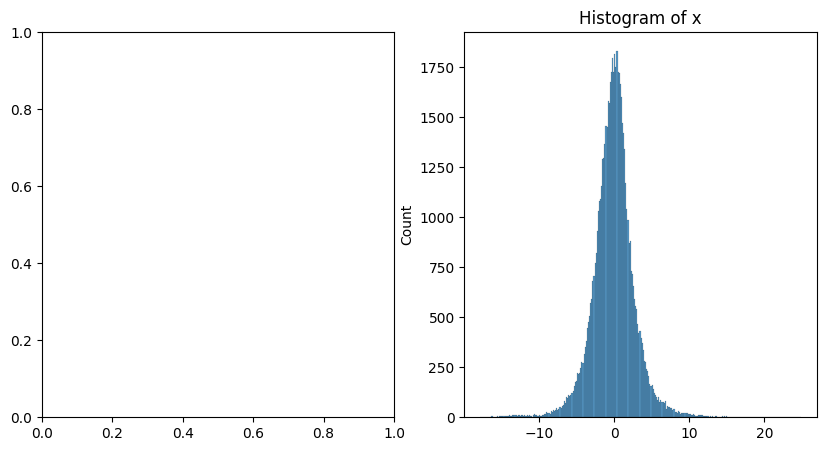

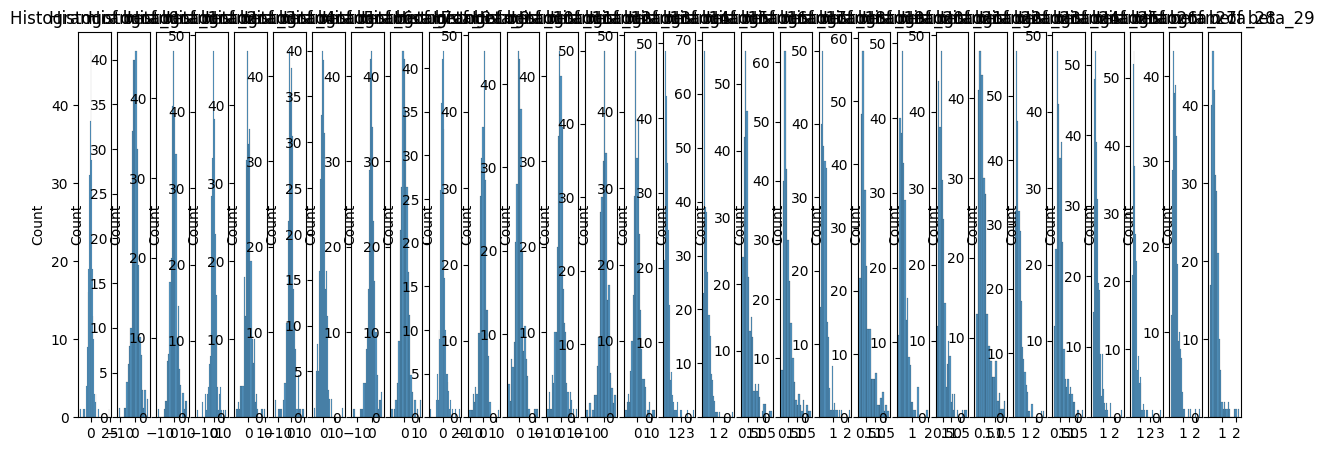

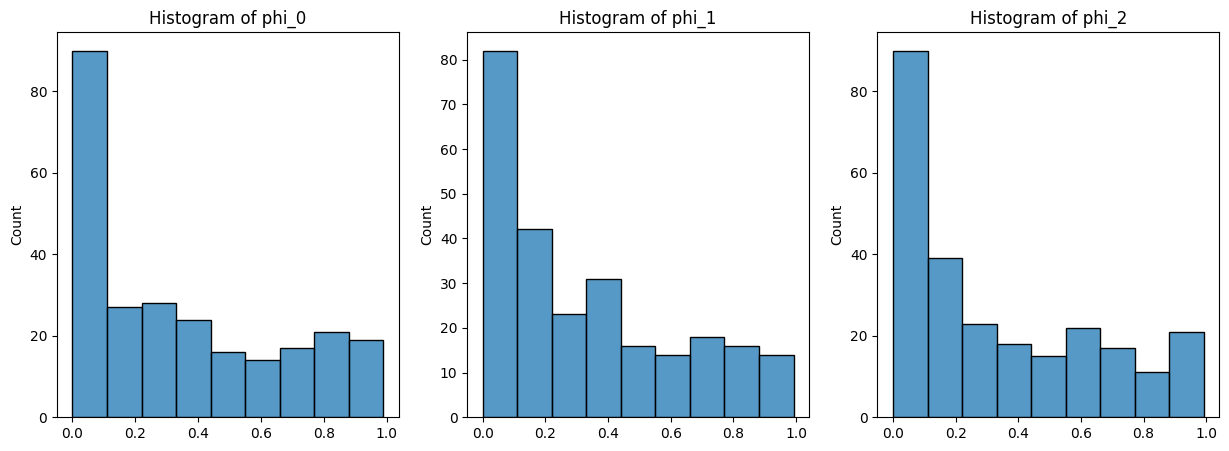

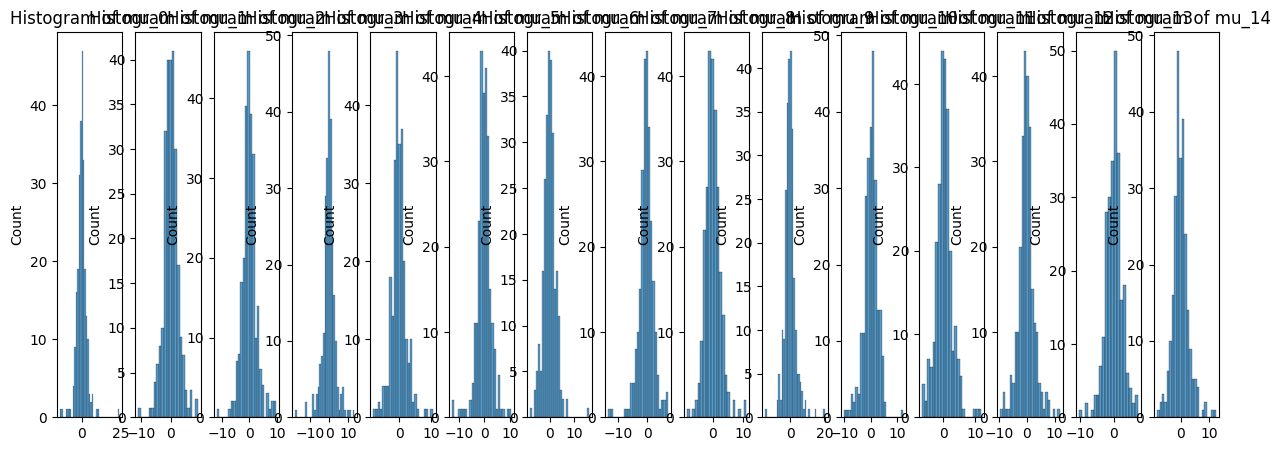

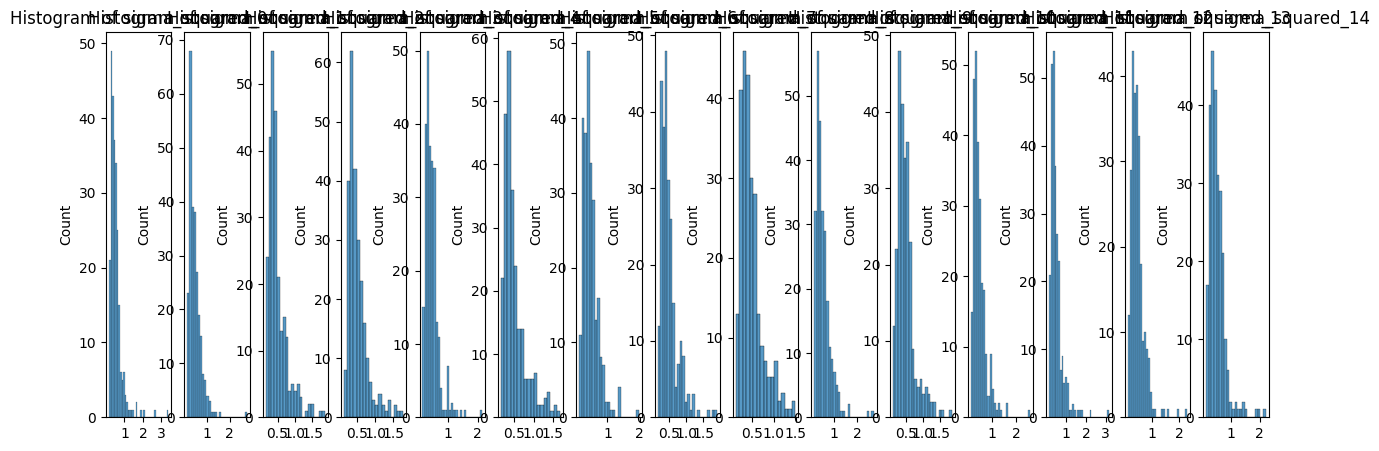

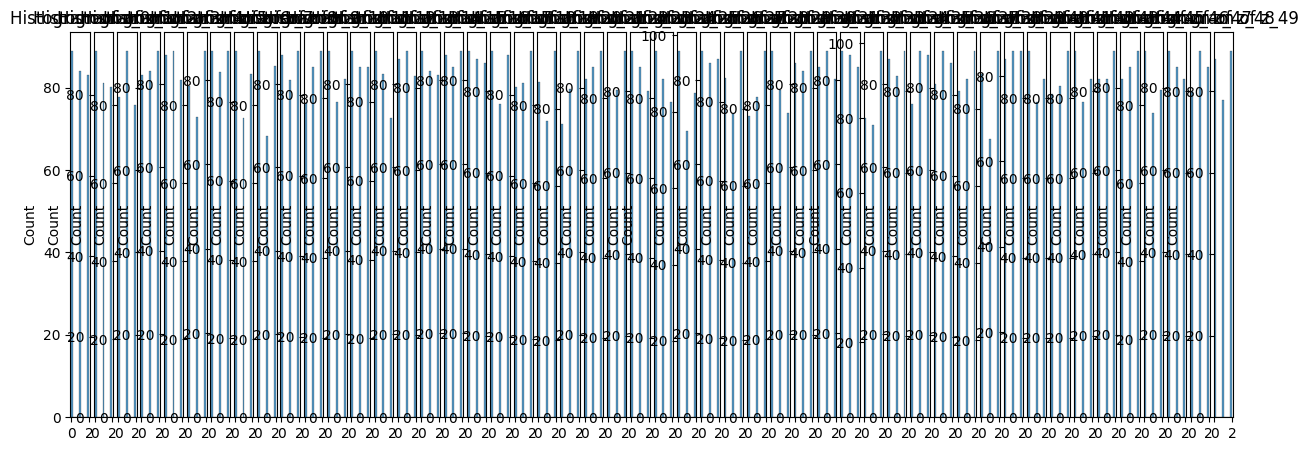

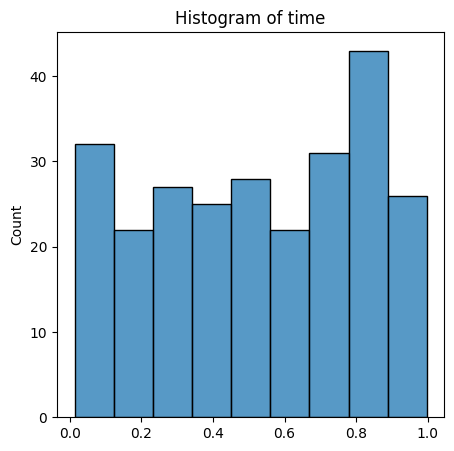

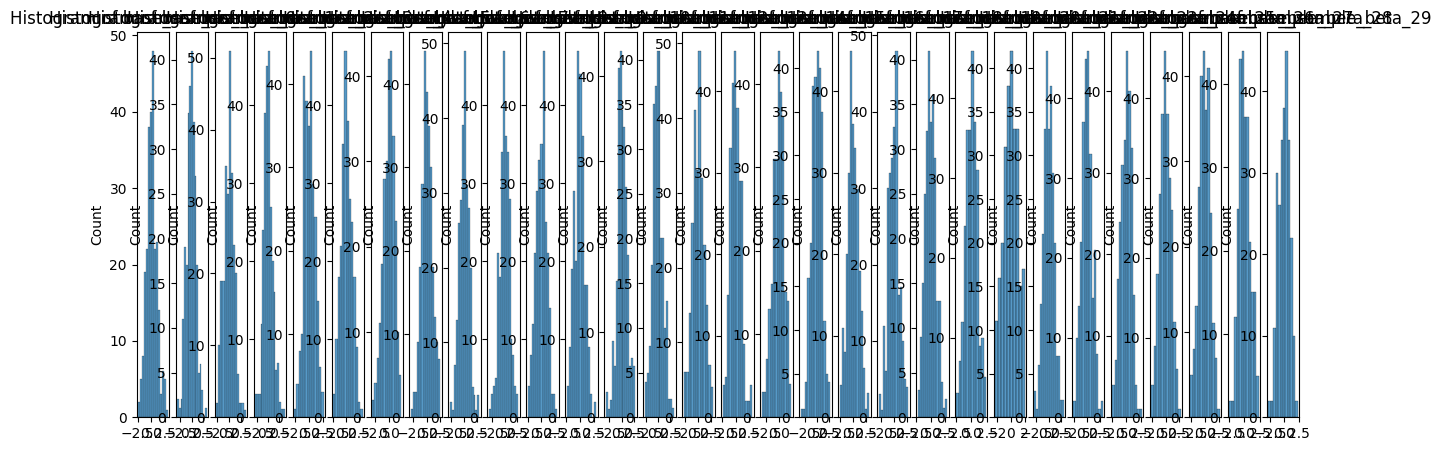

####################################################################################################
Epoch 0




100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


{'X': {'mean': tensor(-0.1085), 'variance': tensor(8.3599), 'min': tensor(-19.9160), 'max': tensor(40.6413), 'mean_mean': tensor([-0.3259, -0.1246, -0.0558, -0.1696,  0.1336]), 'variance_mean': tensor([3.7111, 3.5631, 4.9968, 2.8826, 3.3718]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.2051), 'variance': tensor(3.9743), 'min': tensor(-27.7740), 'max': tensor(36.8648), 'mean_mean': tensor(0.2051), 'variance_mean': tensor(4.0473), 'min_mean': None, 'max_mean': None}}
Statistics for phi:
Mean: tensor([0.3332, 0.3498, 0.3170])
Variance: tensor([0.0856, 0.0862, 0.0847])
Min: tensor([5.3230e-06, 9.8432e-09, 1.8582e-06])
Max: tensor([0.9920, 0.9847, 0.9859])
Mean of means: 0.333333283662796
Mean of variances: 0.1280265748500824
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([-0.3916,  0.0508, -0.1350, -0.1920,  0.0863, -0.2732, -0.0026,  0.1732,
        -0.2730,  0.0500,  0.1402, -0.0195, -0.3595, -0.1135,  0.0062])
Variance: tensor([10.080

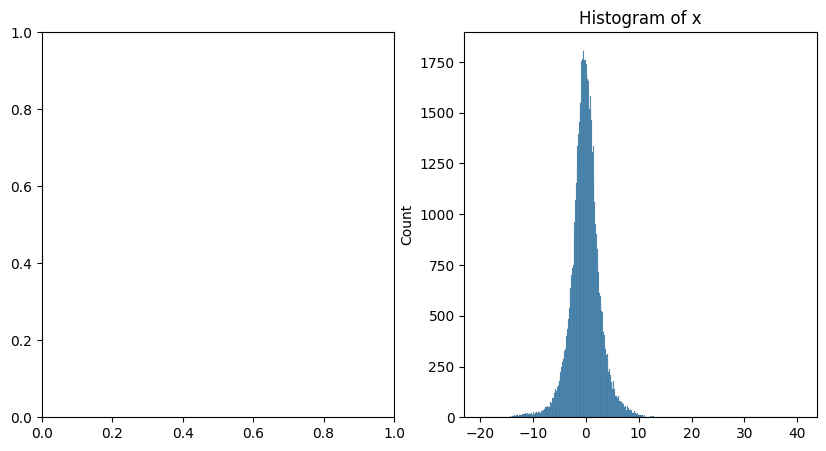

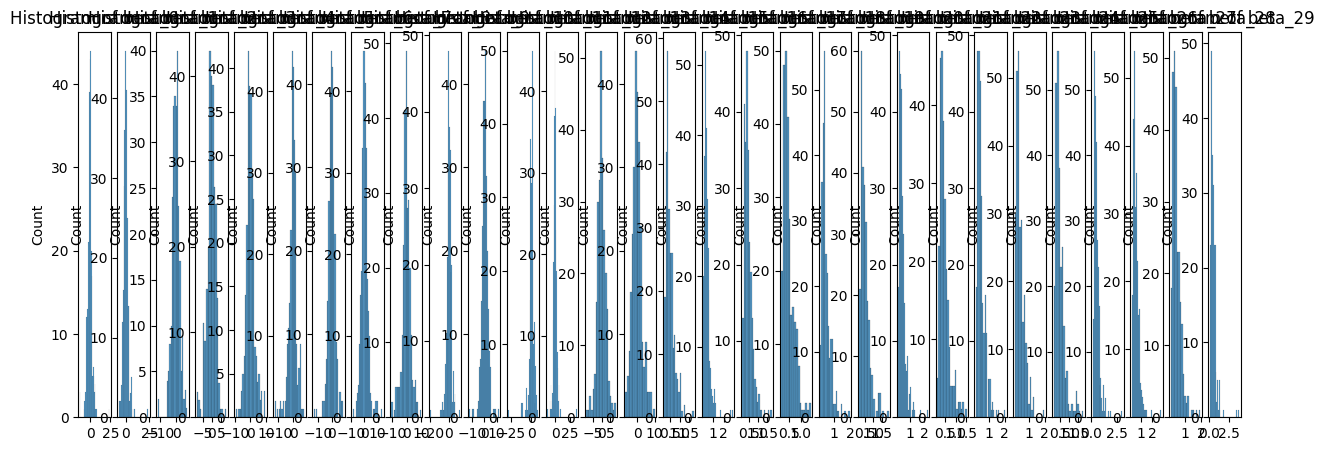

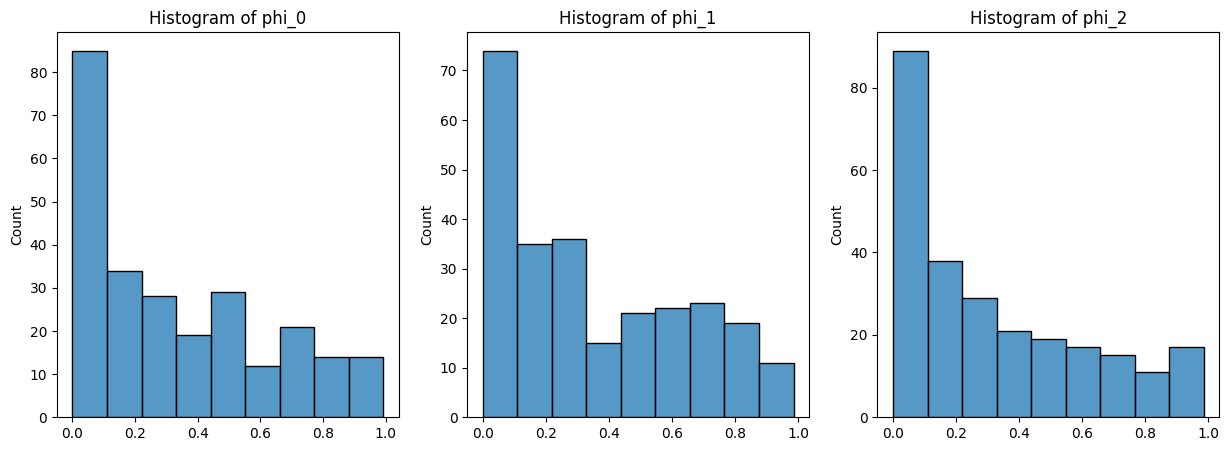

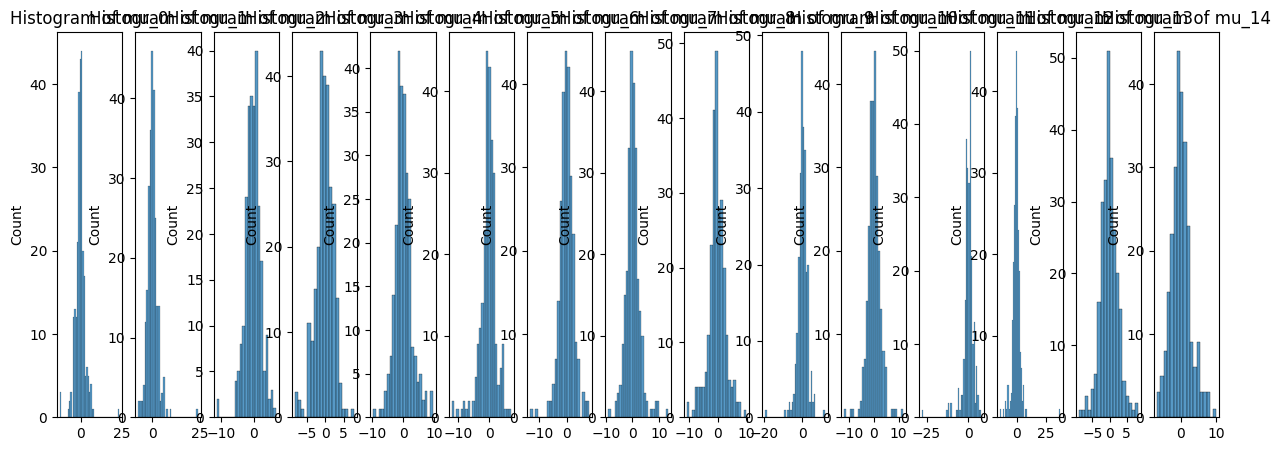

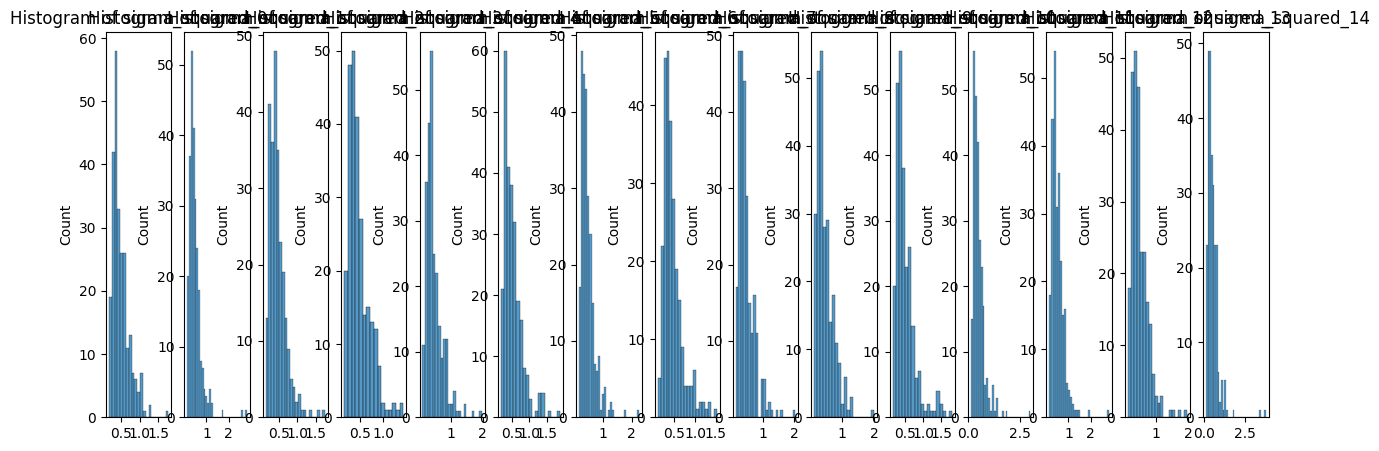

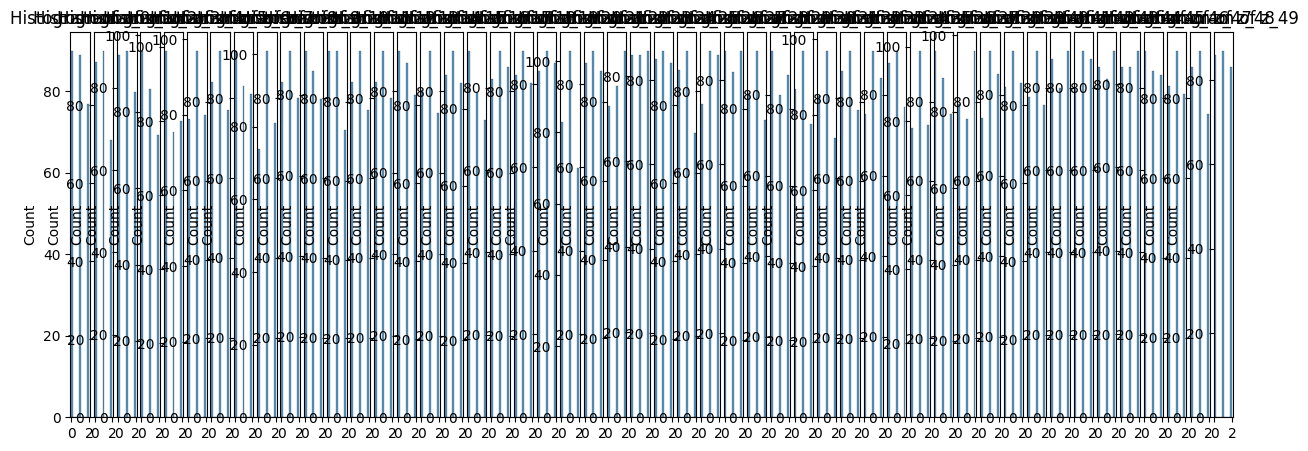

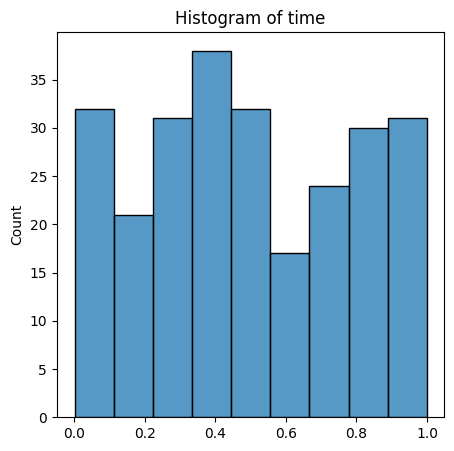

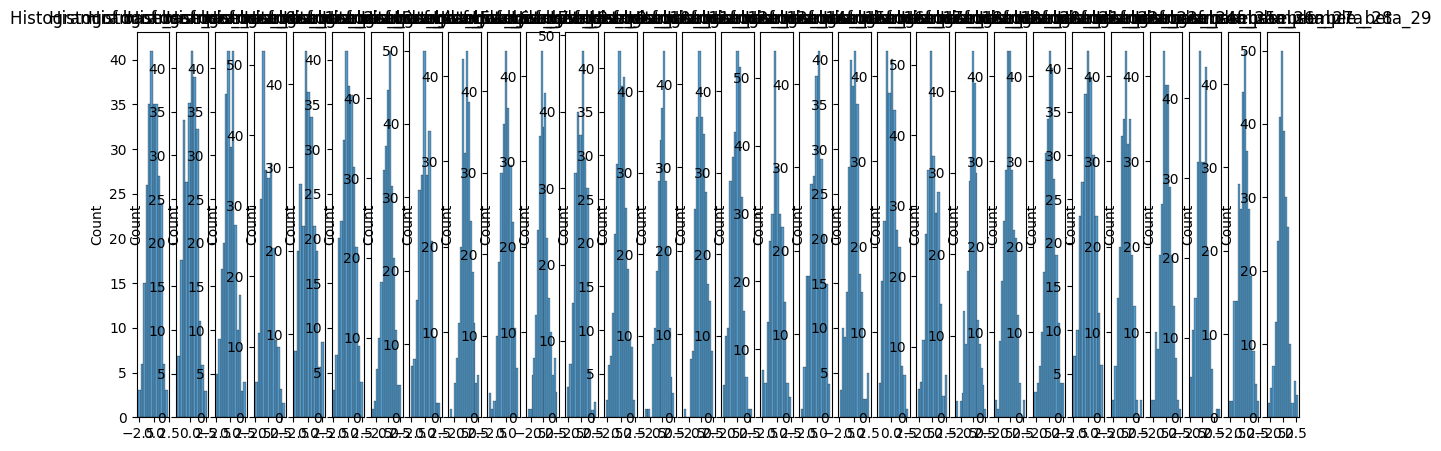

[{'X': {'mean': tensor(-0.0846),
   'variance': tensor(8.0888),
   'min': tensor(-17.8319),
   'max': tensor(24.8544),
   'mean_mean': tensor([-0.1241, -0.1409, -0.2190,  0.1831, -0.1221]),
   'variance_mean': tensor([3.4230, 3.1592, 3.8070, 3.7316, 3.6214]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.2321),
   'variance': tensor(3.8897),
   'min': tensor(-17.7080),
   'max': tensor(24.3131),
   'mean_mean': tensor(0.2321),
   'variance_mean': tensor(3.9573),
   'min_mean': None,
   'max_mean': None}},
 {'X': {'mean': tensor(-0.1085),
   'variance': tensor(8.3599),
   'min': tensor(-19.9160),
   'max': tensor(40.6413),
   'mean_mean': tensor([-0.3259, -0.1246, -0.0558, -0.1696,  0.1336]),
   'variance_mean': tensor([3.7111, 3.5631, 4.9968, 2.8826, 3.3718]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.2051),
   'variance': tensor(3.9743),
   'min': tensor(-27.7740),
   'max': tensor(36.8648),
   'mean_mean': tensor(0.2051),
   'vari

In [94]:
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = P,
    n = N,
    used_batch_samples = 1
)

In [95]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 992 and 496 respectively


In [96]:
sample_batch = next(iter(epoch_loader[0][0]))
sample_batch.keys()

dict_keys(['phi', 'mu', 'sigma_squared', 'z', 'x', 'beta', 'time', 'base_sample_beta'])

In [97]:
sample_batch["x"].shape, sample_batch["beta"].shape

(torch.Size([32, 50, 5]), torch.Size([32, 30]))

In [98]:
2*K

6

In [99]:
"""
model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)
"""

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = P,
    n_input_features_decoder = 2*P*K,
    d_model_encoder = 16,
    d_model_decoder = 16,
    n_heads_encoder = 1,
    n_heads_decoder = 1,
    d_ff_encoder = 16,
    d_ff_decoder = 16,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 16,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P*K,
    d_final_processing = 16,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [100]:
loss_fun = CFMLossOT2(
    sigma_min=1e-4
)

In [101]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(opt,
                       max_lr = 5e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e4)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}



In [102]:
trainer = TrainerCurriculumCNF_LatentFactor(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = None,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [103]:
trainer.validate()




100%|██████████| 4/4 [00:30<00:00,  7.58s/it]


{'loss_mean': 5.26507043838501,
 'loss_median': 5.162500858306885,
 'loss_std': 0.2576553225517273}

In [104]:
r = trainer.train()

Curriculum parameters: {'n': 50, 'p': 5, 'k': 3, 'batch_size': 32, 'a1': 5.0, 'b1': 2.0, 'dirichlet_beta': 0.5, 'lambda1': 5.0} at iteration 0



















100%|██████████| 16/16 [00:35<00:00,  2.20s/it]


100%|██████████| 4/4 [00:00<00:00, 28.24it/s]



100%|██████████| 4/4 [01:05<00:00, 16.28s/it]


Epoch 0:
Training: {'loss_mean': 5.801405429840088, 'loss_median': 5.688615322113037, 'loss_std': 0.6441678404808044}
Validation: {'loss_mean': 6.267292022705078, 'loss_median': 5.165083885192871, 'loss_std': 1.946925401687622}
Validation curriculum: {'loss_mean': 5.218000411987305, 'loss_median': 4.9994940757751465, 'loss_std': 0.38770049810409546}
Time: 100.58463668823242
Learning rate: [0.0002514085105243268]


----------------------------------------------------------------------------------------------------
Saving model









100%|██████████| 13/13 [00:35<00:00,  2.76s/it]

Test: {'loss_mean': 5.355794429779053, 'loss_median': 5.249220848083496, 'loss_std': 0.49142059683799744}


In [143]:
test_batch = next(iter(epoch_loader[0][1]))
x_test = test_batch["x"]

In [355]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (2*P*K,),
    n_samples=1000,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 10,
    rtol = 10,
    #device = torch.device("cpu")
)

benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
del benchmark_params_ppgrogram["batch_size"]
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_gmm_program_diagonal(**benchmark_params_ppgrogram)

#pprogram1_x = return_only_x(pprogram1)



params for pprogram: {'n': 50, 'p': 5, 'k': 3, 'a1': 5.0, 'b1': 2.0, 'dirichlet_beta': 0.5, 'lambda1': 5.0}


In [356]:
import jax.numpy as jnp

In [357]:
x_test[0].shape

torch.Size([50, 5])

In [358]:
P, K

(5, 3)

In [359]:
r = pprogram1(
    #x = jnp.array([x_test[0].numpy()])
    )

z: (50,)
mu: (5, 3)
sigma_squared: (5, 3)
mu_z: (5, 50)
sigma_squared_z: (5, 50)


In [360]:
for k, v in r.items():
    print(k, v.shape)

phi (3,)
mu (5, 3)
sigma_squared (5, 3)
z (50,)
x (50, 5)


In [361]:
hmc = Hamiltionian_MC(
    pprogram=pprogram1,
    n_samples=100,
    n_warmup=100,
    mcmc_kwargs={
        "num_chains":1
    },
    kernel_kwargs={
    }
)

#models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 500)

In [362]:
"""
evaluation = Evaluate(
    posterior_model = models[1],
    evaluation_loader = trainer.testset,
    comparison_models= [hmc],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)
"""

evaluation = Evaluate(
    posterior_model = hmc,
    evaluation_loader = trainer.testset,
    comparison_models= [],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_posterior_model = result_dict_to_latent_variable_convert_mu_sigma_to_beta,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [363]:
evaluation.run_evaluation()


Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]


x: (50, 5)
z: (50,)
mu: (5, 3)
sigma_squared: (5, 3)
mu_z: (5, 50)
sigma_squared_z: (5, 50)
x: (50, 5)
z: (3, 1, 1)
mu: (5, 3)
sigma_squared: (5, 3)
mu_z: (5, 3, 1, 1)
sigma_squared_z: (5, 3, 1, 1)


ValueError: Incompatible shapes for broadcasting: shapes=[(50,), (1, 1, 3)]

Warmup:  35%|███▌      | 7/20 [2:51:55, 1473.57s/it, step size=2.06e-02, acc. prob=0.643]


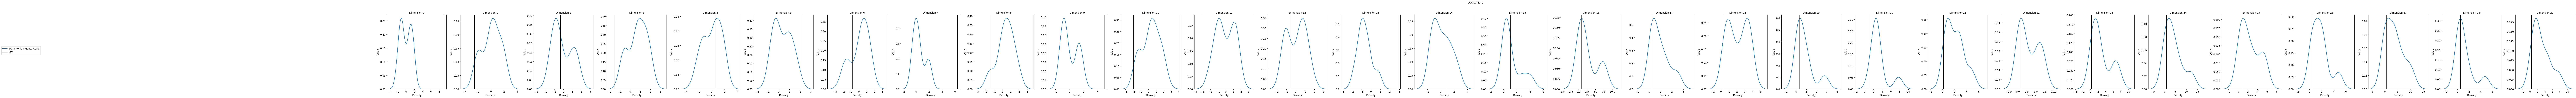

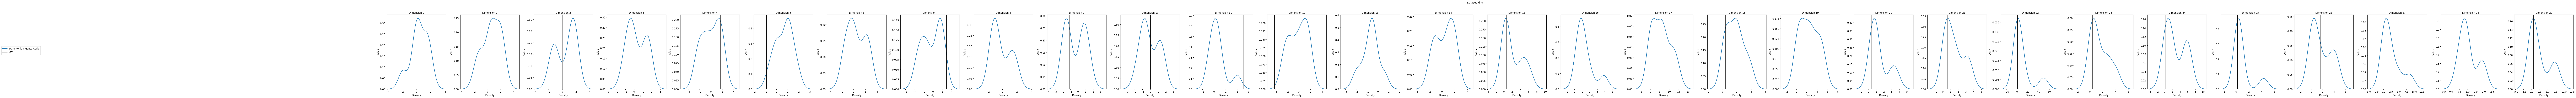

In [77]:
evaluation.plot_results()

In [78]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [79]:
from PFNExperiments.Evaluation.RealWorldEvaluation.Preprocess_multivariate_GMM import Preprocessor_GMM_multivariate
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = Preprocessor_GMM_multivariate(
        N_datapoints = N,
        P_features = P,
        x_mean = 0.0,
        x_var = 1.0,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

In [80]:
comparison_models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000)

NameError: name 'pprogram1_x' is not defined

In [38]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld


eval = EvaluateRealWorld(
    
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = comparison_models[1:3],
    n_evaluation_cases = 2,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [39]:
eval.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [02:29<02:29, 149.09s/it]

....................


Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [02:47<02:47, 167.55s/it]

....................


Sampling posterior: 100%|██████████| 2/2 [05:27<00:00, 163.62s/it]


Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,10.575329,3.965482,1.0,0.124732,0.167943,0.0
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,9.419564,3.604070,1.0,0.053669,0.132949,0.0
2,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,6.791085,5.342443,1.0,0.161377,0.561083,0.0


P-values:


,Pair 1: Model A,Pair 1: Model B,Pair 2: Model A,Pair 2: Model B,Wasserstein_distance with metric euclidean_p-value,MMD_p-value,cst_roc_auc_p-value
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,0.245278,0.245278,1.0
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,0.245278,0.245278,1.0
2,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,0.245278,0.245278,1.0


{'summarized_results': {'model_comparison_among_each_other':                                              Model 1  \
  0  <PFNExperiments.LinearRegression.Models.ModelT...   
  1  <PFNExperiments.LinearRegression.Models.ModelT...   
  2  Variational Inference with guide: _bound_parti...   
  
                                               Model 2  \
  0  Variational Inference with guide: _bound_parti...   
  1  Variational Inference with guide: _bound_parti...   
  2  Variational Inference with guide: _bound_parti...   
  
     Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
  0                                        10.575329  3.965482   
  1                                         9.419564  3.604070   
  2                                         6.791085  5.342443   
  
     Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean   Std_MMD  \
  0               1.0                                        0.124732  0.167943   
  1               1.0                 